## prediction of movie rating
### features
    * actors average rating
    * directors average rating
    * budget
    * revenue
    

#### data is restricted on movie release year ( after 1980 )

## the model
#### linear regression is simulated with a neural network

## required modules

In [1]:
import numpy as np  # array numerical computations 
import pandas as pd  # data-frame data structures
import matplotlib.pyplot as plt  # plotting
import seaborn as sns  # plotting
import tensorflow as tf  # machine learning module
from tensorflow import keras  # deep learning (sub-module of tensorflow)
from tensorflow.keras import layers

C:\Users\amir\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## load prepared datasets

In [3]:
movies_data = pd.read_csv('F:\\IMDb Data\\Kaggle Data\\main_data\\movies_data.csv')
genres_data = pd.read_csv('F:\\IMDb Data\\Kaggle Data\\main_data\\genres_data.csv')
directors_data = pd.read_csv('F:\\IMDb Data\\Kaggle Data\\main_data\\directors_data.csv')
writers_data = pd.read_csv('F:\\IMDb Data\\Kaggle Data\\main_data\\writers_data.csv')
producers_data = pd.read_csv('F:\\IMDb Data\\Kaggle Data\\main_data\\producers_data.csv')
actors_data = pd.read_csv('F:\\IMDb Data\\Kaggle Data\\main_data\\actors_data.csv')
cinematographers_data = pd.read_csv('F:\\IMDb Data\\Kaggle Data\\main_data\\cinematographers_data.csv')
editors_data = pd.read_csv('F:\\IMDb Data\\Kaggle Data\\main_data\\editors_data.csv')
composers_data = pd.read_csv('F:\\IMDb Data\\Kaggle Data\\main_data\\composers_data.csv')
kaggle_data = pd.read_csv('F:\\IMDb Data\\Kaggle350\\AllMoviesDetailsCleaned.csv', sep=';')

C:\Users\amir\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## selecting relevant datas

In [4]:
kaggle_dataset = kaggle_data[['imdb_id', 'budget', 'revenue']]

In [5]:
kaggle_dataset = kaggle_dataset[kaggle_dataset['budget'] != 0]
kaggle_dataset = kaggle_dataset[kaggle_dataset['revenue'] != 0]
kaggle_dataset = kaggle_dataset.set_index('imdb_id')

In [6]:
kaggle_dataset.head()

,budget,revenue
imdb_id,,
tt0113101,4000000,4300000
tt0076759,11000000,775398007
tt0266543,94000000,940335536
tt0109830,55000000,677945399
tt0169547,15000000,356296601


In [7]:
d = movies_data
d = movies_data[movies_data['startYear'] > 1980]

In [8]:
data = d.set_index('tconst')
data = data.join(directors_data.set_index('tconst'), how='inner')
data = data.join(actors_data.set_index('tconst'), how='inner')
data = data.join(kaggle_dataset, how='inner')

## visualizing the data

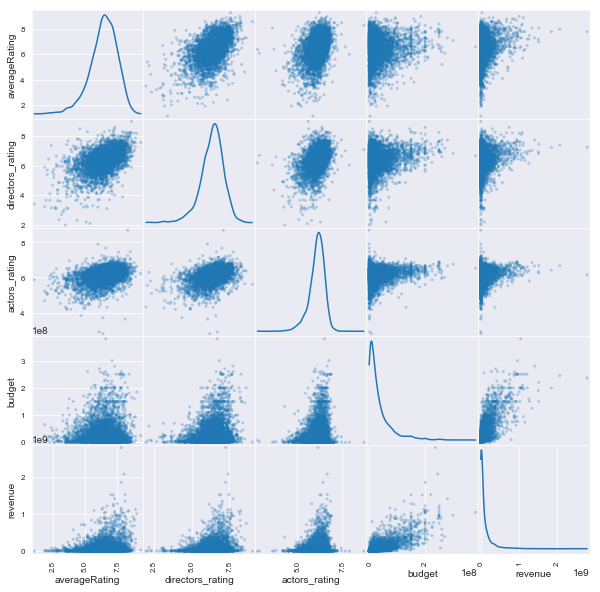

In [10]:
data = data.sample(frac=1)  ## Shuffling the data

sns.set_style('darkgrid')

pd.plotting.scatter_matrix(data[['averageRating', 'directors_rating', 'actors_rating', 'budget', 'revenue']], alpha=0.3, figsize=(10, 10), diagonal='kde')
plt.show()

In [11]:
raw_dataset = data[['averageRating', 'directors_rating', 'actors_rating', 'budget', 'revenue']]
dataset = raw_dataset.copy()
dataset.head()

,averageRating,directors_rating,actors_rating,budget,revenue
tt1571222,6.4,6.595000,6.553745,15000000,27462041
tt2097245,5.9,6.300000,4.880556,5000000,13645556
tt0092099,6.9,6.756250,6.348520,15000000,356830601
tt5592248,6.3,6.583333,6.429717,10500000,5535981
tt0408524,5.8,7.182353,6.328361,30000000,34252847


In [12]:
dataset.shape

(4497, 5)

## getting the data ready for machine learning

### there are several steps involved
    * deal with missing values
    * split data into training and testing data
    * split the target values
    * normalizing the data

In [13]:
# deal with missing values  -- already taken care of.

# split data into training and testing data
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

C:\Users\amir\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


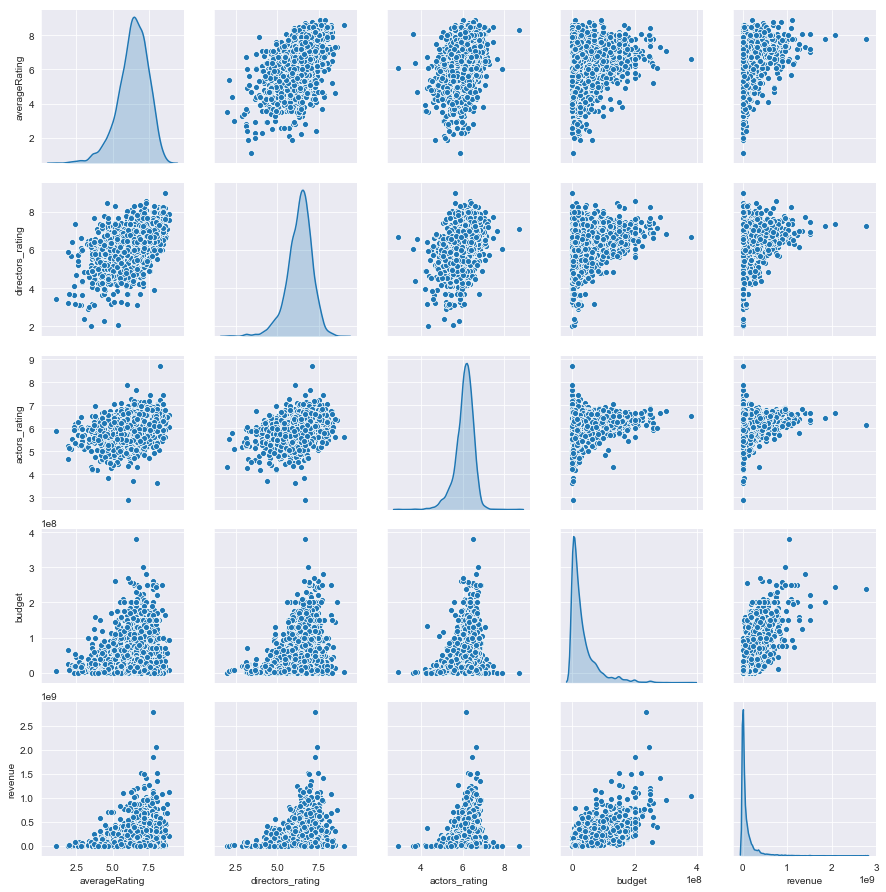

In [14]:
sns.pairplot(train_dataset[['averageRating', 'directors_rating', 'actors_rating', 'budget', 'revenue']], diag_kind="kde")

In [15]:
train_stats = train_dataset.describe()
train_stats.pop("averageRating")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
directors_rating,3598.0,6.355770e+00,7.624234e-01,2.0,5.935561e+00,6.433333e+00,6.844444e+00,9.000000e+00
actors_rating,3598.0,6.095992e+00,4.309265e-01,2.9,5.886985e+00,6.147207e+00,6.376095e+00,8.700000e+00
budget,3598.0,3.429975e+07,4.261035e+07,1.0,6.500000e+06,2.000000e+07,4.500000e+07,3.800000e+08
revenue,3598.0,9.962247e+07,1.803517e+08,1.0,6.733716e+06,3.300000e+07,1.132151e+08,2.781506e+09


In [16]:
# split the target values
train_labels = train_dataset.pop('averageRating')
test_labels = test_dataset.pop('averageRating')

In [17]:
# normalizing the data
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## the learning model. 

### we wish to simulate linear regression with neural networks;
    * 1 dense layer with 1 neuron with linear activation function.
    * Stochastic gradient descent for the optimizer.
    * 'mean squared error' for the objective function of the minimization process ( loss function ).

In [18]:
def build_model():
    model = keras.Sequential([
        layers.Dense(1, input_shape=[len(normed_train_data.keys())]),
    ])    
        
    optimizer = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    
    return model

In [19]:
model = build_model()

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [21]:
# pre training the result of the model is pretty random.

example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 1.1051518 ],
       [-0.09576979],
       [ 0.8167447 ],
       [-1.4205074 ],
       [-1.7150924 ],
       [-0.07547042],
       [-0.47904867],
       [ 0.19409311],
       [ 0.21736813],
       [ 0.6732662 ]], dtype=float32)

## training the model

In [22]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

        
# this function is used to draw the metric diagram
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [averageRating]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()
  
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$averageRating^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

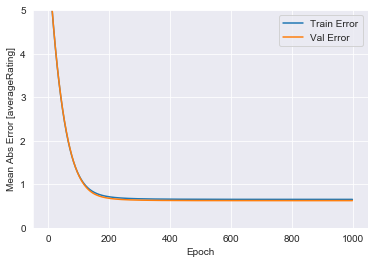

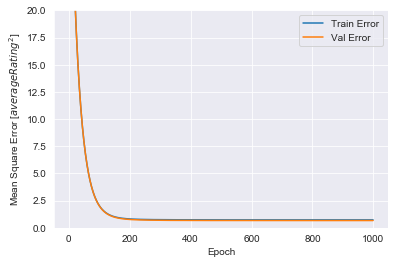

In [23]:
# the number of training cycles
# in each cycle the model will look through all the training data once
EPOCHS = 1000

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [24]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
995,0.667659,0.624429,0.667659,0.729289,0.653421,0.729289,995
996,0.667658,0.624429,0.667658,0.729290,0.653427,0.729290,996
997,0.667657,0.624428,0.667657,0.729287,0.653423,0.729287,997
998,0.667657,0.624428,0.667657,0.729287,0.653421,0.729287,998
999,0.667656,0.624428,0.667656,0.729287,0.653420,0.729287,999


## testing the model
#### it is important to mention that the blue graph in the above represents the validation data not the test data. the test data has not been involved at all in the training process

#### Testing set Mean Abs Error is a measure of how accurate the predictions are.

##### TRUE_VAL on average in the interval [ PREDICTED_VAL -  MAE ,  PREDICTED_VAL +  MAE]

In [25]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} averageRating".format(mae))

Testing set Mean Abs Error:  0.66 averageRating


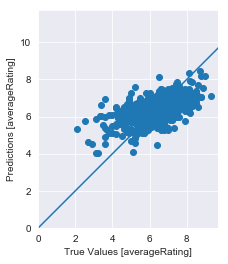

In [26]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [averageRating]')
plt.ylabel('Predictions [averageRating]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

### if the prideiction were 100% accurate all the data points would lie on the y=x line.

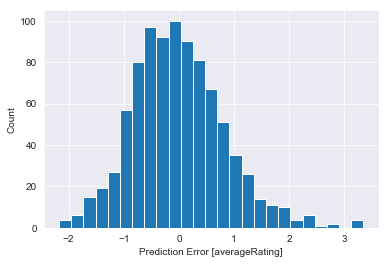

In [27]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [averageRating]")
_ = plt.ylabel("Count")

### the histogram of the prediction error is close to gaussian (as expected).